In [2]:
from pprint import pprint as pp
from datetime import datetime, date, timedelta, timezone
import pandas as pd
import numpy as np
import os
import pytz
from collections import ChainMap, OrderedDict
from pwe.hyptest import ttest_1samp_,ttest_ind_
import pwe.pwetools as pwe
from pwe import charts,cme,ta
from pwe.analysis import Security
#pd.options.display.float_format = '{:,.2f}'.format

# pip install -U textblob
from textblob import TextBlob
import re

# pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# pip install -U scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier

import json 
import requests 
import backtrader as bt
import backtrader.analyzers as btanalyzers
#import qgrid
from pwe.cmc import binance
import pyfolio as pf
from time import time
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from pathlib import Path
import csv
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine
from scrapy.exceptions import DropItem
from FiScrape.models import Article, Tag, db_connect, create_table, Topic, Source, Author, SnipBlob, Blob, SnipVader, Vader #  create_output_table
# from FiScrape.spiders.FiSpider import query
import logging

/Users/zenman618/opt/anaconda3/envs/pwepip/lib/python3.9/site-packages/pyfolio/pos.py:26: UserWarning:

Module "zipline.assets" not found; multipliers will not be applied to position notionals.



In [3]:
# from google.colab import files
# files.upload()

In [4]:
start_date = pwe.to_utc('2019-12-21')
print (start_date)

end_date = pytz.utc.localize(datetime.utcnow())
print (end_date)

Assuming naive datetime: 2019-12-21 00:00:00 is already in UTC and labelling it as such. Ensure this is correct.
2019-12-21 00:00:00+00:00
2021-09-26 12:43:02.522348+00:00


In [5]:
# username=cme_user
# password=cme_pass
# ## Settings for reading most recent local data:
# brr, brti_1h = cme.get_cme(username=username, password=password, dataset='CRYPTOCURRENCY',hzn='any',
#                  dir='Users/zenman618/Documents/git_packages/VisualStudioGit/pwe_analysis/csv_files/CME/Crypto',
# index_col='DateTime', limit=2, processes=1, resample=True, interval='1h', symbols=['BRR', 'BRTI'])
# brti_1h.tail()

In [6]:
symbol = 'BTCUSDT'
interval='1h'

# Enter the time in GMT, with naive format. Binance API is inconsistent and doesn't use TZ aware dates for this endpoint. It imterprets dates as your local tz and returns naive GMT.
btc_usdt = binance(symbol='BTCUSDT',start_date=start_date,end_date="2021-09-26 11:00:00", interval=interval, your_tz="Asia/Dubai") # "2021-09-16 23:00:00"
btc_usdt = btc_usdt.drop(columns=['Dt_Asia_Dubai'])
btc_usdt


Security: BTCUSDT
Interval: 1h

Checking if a file for this ticker with the same start and end dates exists...
Matching local file exists.
Reading recent file from CSV...
/Users/zenman618/Documents/git_packages/VisualStudioGit/FiScrape/csv_files/Binance/BTCUSDT_1h_2019-12-21_00,00,00_2021-09-26_11,00,00.csv


,Open,High,Low,Close,Volume
DateTime,,,,,
2019-12-21 00:00:00+00:00,7188.01,7190.58,7154.14,7164.54,861.010276
2019-12-21 01:00:00+00:00,7164.54,7172.08,7142.30,7157.98,786.375514
2019-12-21 02:00:00+00:00,7157.40,7174.98,7151.77,7167.78,616.891823
2019-12-21 03:00:00+00:00,7167.12,7170.00,7152.00,7156.01,826.723512
2019-12-21 04:00:00+00:00,7156.03,7175.43,7142.10,7147.37,858.744363
...,...,...,...,...,...
2021-09-26 07:00:00+00:00,41963.13,42060.00,40750.00,41231.34,5678.138050
2021-09-26 08:00:00+00:00,41227.07,41691.31,41037.13,41607.53,4167.656810
2021-09-26 09:00:00+00:00,41607.53,43746.90,41500.68,43251.33,7240.368820


In [7]:
# bin_vs_brti = btc_usdt.join(brti_1h, lsuffix="_Bin", rsuffix="_BRTI")

# charts.pwe_line_chart(bin_vs_brti,columns=['Close_Bin', 'Close_BRTI'],start_date=start_date,end_date=end_date,kind='scatter',title='Binance BTCUSDT vs CME BRTI',
#                   ticker='BTCUSDT',yTitle='BTC/USD',asPlot=True,showlegend=False,theme='white',
#                  auto_start='2021-01-01',auto_end=None,connectgaps=False,annots=None,annot_col=None)

In [8]:
btc_usdt = btc_usdt.fillna(method="ffill")

btc_usdt.name = "btc_usdt"
btc_usdt = Security(btc_usdt)

trading_periods = 365
market_hours = 24
vol_window = 30
interval = 'hourly'

pwe.sort_index(btc_usdt.df)
pwe.split_datetime(btc_usdt.df,date=True,year=True,quarter=True,month=True,day=False,dow=True,time=True,hour=True)
btc_usdt.get_returns()
btc_usdt.get_vol(window=vol_window,trading_periods=trading_periods,interval=interval,market_hours=market_hours);
btc_usdt.YangZhang_estimator(window=vol_window, trading_periods=trading_periods,interval=interval,market_hours=market_hours);

btc_usdt_expirations, btc_usdt_last_fris_df, btc_usdt.df = pwe.get_exp_dates(btc_usdt.df, start=None, end=None, freq='D', time='15:00:00', exp_tz='London', expires='last_fri', name='CME Exp.')
btc_usdt_expirations, btc_usdt_last_fris_df, btc_usdt.df = pwe.get_exp_dates(btc_usdt.df, start=None, end=None, freq='h', time='15:00:00', exp_tz='London', expires='last_fri', name='CME Exp.')
pwe.expir_delta(btc_usdt.df, interval='h', expirations_df=btc_usdt_last_fris_df)
btc_usdt.df.drop(columns='DateTime', inplace=True)

nans = btc_usdt.df['Price_Returns'].isnull().value_counts()
nans

Searching for TZ...
Timezone: Europe/London

First expiration date: ('2019-12-27', 'CME Exp.')
Last expiration date: ('2021-09-24', 'CME Exp.')
Expiration dates in range: 22
Found expiration dates: 22
Missing expiration dates: 0
Searching for TZ...
Timezone: Europe/London

First Expiration_DateTime: ('2019-12-27 15:00:00', 'CME Exp.')
Last expiration date: ('2021-09-24 14:00:00', 'CME Exp.')
Expiration dates in range: 22
Expiration day datetimes in range: 22
Found expiration day datetimes: 22
Missing expiration day datetimes: 0


False    15403
True         1
Name: Price_Returns, dtype: int64

In [9]:
trading_periods = 365
market_hours = 24
vol_window = 30
interval = 'hourly'

btc_usdt.stats(trading_periods=trading_periods,interval=interval,market_hours=market_hours,vol_window=vol_window);



btc_usdt Return Stats:
Dates: 2019-12-21 00:00:00+00:00 - 2021-09-26 11:00:00+00:00
Periods: 15403 hours
Trading Periods: 365 days a year
Years: 1.76

Cumulative Returns: 502.18%

Arithmetic Mean Return: 0.015592%
Geometric Mean Return: 0.011657%

Median Return: 0.015858%

Annualaized Arithmetic Return: 291.88%
Annualized Geometric Return: 177.62%
 
Vol. of Period Returns: 0.888650%
Mean Volatility (30): 0.728879%
Mean YangZhang (30): 0.847479%

Annualized Vol: 83.17%
Annualized Mean Volatility (30): 68.22%
Annualized Mean YangZhang (30): 79.32%

Arithmetic Sharpe Ratio: 3.51
Geometric Sharpe Ratio: 2.14
 
Return Summary self:
count    15403.000000
mean         0.000156
std          0.008850
min         -0.182115
25%         -0.002964
50%          0.000159
75%          0.003398
max          0.173840
Name: Price_Returns, dtype: float64
Jarque-Bera: Jarque_beraResult(statistic=1617490.775674029, pvalue=0.0)
Kurtosis: 53.190991410631426
Skew: -0.5334472746918412
######



In [10]:
df = btc_usdt.df

# df = df.join(brr, how='left')

ta.ama(df,price='Close', window=9,fast_period=6,slow_period=12,fillna=False)
ta.bol_bands(df,window=20,std=2,price='Close',fillna=False, lib=False, inputs=None)
ta.kalman_filter(df, price='Close', transition_matrices=[1], observation_matrices=[1], initial_state_mean=0, initial_state_covariance=1,
                    observation_covariance=1, transition_covariance=.01)

df['target'] = np.where(df['Price_Returns']>0, 1, np.where(df['Price_Returns']<0, -1, 0))
df

,Open,High,Low,Close,Volume,Date,Year,Quarter,Month,Day_of_Week,...,AMA_6_12,bb_bbh_2_20,bb_bbm_2_20,bb_bbl_2_20,bb_bbhi_2_20,bb_bbli_2_20,bb_bbw_2_20,bb_bbp_2_20,Kalman_Filter,target
DateTime,,,,,,,,,,,,,,,,,,,,,
2019-12-21 00:00:00+00:00,7188.01,7190.58,7154.14,7164.54,861.010276,2019-12-21,2019,4,12,5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,3582.270000,0
2019-12-21 01:00:00+00:00,7164.54,7172.08,7142.30,7157.98,786.375514,2019-12-21,2019,4,12,5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,4789.960132,-1
2019-12-21 02:00:00+00:00,7157.40,7174.98,7151.77,7167.78,616.891823,2019-12-21,2019,4,12,5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,5403.489302,1
2019-12-21 03:00:00+00:00,7167.12,7170.00,7152.00,7156.01,826.723512,2019-12-21,2019,4,12,5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,5773.919558,-1
2019-12-21 04:00:00+00:00,7156.03,7175.43,7142.10,7147.37,858.744363,2019-12-21,2019,4,12,5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,6022.853702,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-26 07:00:00+00:00,41963.13,42060.00,40750.00,41231.34,5678.138050,2021-09-26,2021,3,9,6,...,42548.140108,43091.120543,42388.2465,41685.372457,0.0,1.0,3.316363,-0.322983,42291.521290,-1
2021-09-26 08:00:00+00:00,41227.07,41691.31,41037.13,41607.53,4167.656810,2021-09-26,2021,3,9,6,...,42502.837961,43132.477609,42351.3740,41570.270391,0.0,0.0,3.688681,0.023851,42226.456672,1
2021-09-26 09:00:00+00:00,41607.53,43746.90,41500.68,43251.33,7240.368820,2021-09-26,2021,3,9,6,...,42526.558889,43261.890366,42388.9395,41515.988634,0.0,0.0,4.118767,0.993951,42323.947667,1


In [11]:
# df['bb_bbw_2_20'].value_counts()
df['bb_bbw_2_20'].isna().value_counts()

False    15385
True        19
Name: bb_bbw_2_20, dtype: int64

In [12]:
pwe.candle_close_dt(df, mins=59, secs=59)

# Add News Sentiment

In [13]:
from sqlalchemy import asc, desc, func
# con = 'sqlite:///FiScrape_01.db'
uri = 'sqlite:///FiScrape.db'
# from os import environ
# uri = environ.get('CONNECTION_STRING')
# from scrapy.utils.project import get_project_settings
# uri = get_project_settings().get("CONNECTION_STRING")
# self.engine = create_engine(db_uri, echo=True)

In [14]:
# engine = db_connect()
engine = create_engine(uri)
# create_table(engine)
Session = sessionmaker(bind=engine)
session = Session()
connection = engine.connect()
logging.info("****_NLP_Pipeline: database connected****")

# link ="https://www.ft.com/content/7200b459-265a-44fc-a31c-3843e4802f75"
# exist_article = session.query(Article).filter_by(article_link = link).first()
# #articles = session.query(Article).all()
# warnings.filterwarnings('ignore')

In [20]:
# articles = get_total_articles(session)
# pd.read_sql_query(sql, con, index_col=None, coerce_float=True, params=None, parse_dates=None, chunksize=None, dtype=None)
# df_arts = pd.read_sql(articles, uri, index_col='published_date', coerce_float=True, params=None, parse_dates='published_date',
#                     columns=None, chunksize=None)

In [21]:
def get_snippet_sent(connection, pub_source='ft'):
    """Get a list of blob and VADER scores for a publication, ordered by datetime.
    pub_source  :   Publication source name. e.g. 'bloomberg', or 'ft'.
    """
    # sql = '''SET NOCOUNT ON
    # CREATE TEMP TABLE temp_sent AS SELECT published_date, id FROM article WHERE article.source_id ='1';
    # CREATE TEMP TABLE temp_sent2 AS SELECT temp_sent.id, published_date, subjectivity, polarity FROM temp_sent INNER JOIN snip_blob ON snip_blob.article_id = temp_sent.id;
    # CREATE TEMP TABLE sentiment AS SELECT temp_sent2.id, published_date, subjectivity, polarity, compound, negative, neutral, positive FROM temp_sent2 INNER JOIN snip_vader ON snip_vader.article_id = temp_sent2.id;
    # SELECT * FROM sentiment;
    # '''
    sql1 = f"CREATE TEMP TABLE temp_sent AS SELECT published_date, id FROM article WHERE article.source_id = (SELECT rowid FROM Source WHERE name = '{pub_source}');"
    connection.execute(sql1)
    sql2 = "CREATE TEMP TABLE temp_sent2 AS SELECT temp_sent.id, published_date, subjectivity, polarity FROM temp_sent INNER JOIN snip_blob ON snip_blob.article_id = temp_sent.id;"
    connection.execute(sql2)
    sql3 = "CREATE TEMP TABLE sentiment AS SELECT temp_sent2.id, published_date, subjectivity, polarity, compound, negative, neutral, positive FROM temp_sent2 INNER JOIN snip_vader ON snip_vader.article_id = temp_sent2.id;"
    connection.execute(sql3)

    query_str = "SELECT * FROM sentiment;"
    # query_str = sql
    df_sent = pd.read_sql(query_str, con=connection, index_col='published_date', coerce_float=True, parse_dates='published_date')
    connection.execute("DROP TABLE temp_sent")
    connection.execute("DROP TABLE temp_sent2;")
    connection.execute("DROP TABLE sentiment;")
    return df_sent
    

In [22]:
from FiScrape.sql_tools import uri, get_snippet_sent

ft = get_snippet_sent(uri, pub_source='ft')
ft

,id,subjectivity,polarity,compound,negative,neutral,positive
published_date,,,,,,,
2021-09-24 20:56:01,1,0.250000,0.062500,0.2500,0.076,0.805,0.119
2021-09-23 17:28:26,2,0.300000,-0.066667,0.0000,0.000,1.000,0.000
2021-09-24 13:51:19,3,0.500000,0.000000,0.1027,0.000,0.952,0.048
2021-09-24 17:47:57,4,0.300000,0.250000,-0.2500,0.111,0.889,0.000
2021-09-23 07:14:13,5,0.636161,0.071875,-0.1027,0.041,0.959,0.000
...,...,...,...,...,...,...,...
2021-08-20 04:00:35,875,0.651515,0.045455,-0.4019,0.070,0.930,0.000
2021-08-22 23:01:03,876,0.142857,0.045714,0.3818,0.000,0.929,0.071
2021-08-23 07:12:49,877,0.269444,0.041667,0.2263,0.000,0.940,0.060


In [23]:
ft = pwe.sort_index(ft)
ft = pwe.to_utc(ft)
ft.columns = ft.columns.str.capitalize()
ft

Assuming naive DateTime Index is already in UTC and labelling it as such. Ensure this is correct.


,Id,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
published_date,,,,,,,
2019-12-22 12:00:26+00:00,560,0.000000,0.000000,-0.3182,0.062,0.938,0.000
2019-12-23 04:00:28+00:00,561,0.362576,0.077273,0.0000,0.000,1.000,0.000
2019-12-24 00:00:27+00:00,562,0.000000,0.000000,-0.1280,0.043,0.957,0.000
2019-12-24 18:37:01+00:00,563,0.000000,0.000000,0.4404,0.000,0.919,0.081
2019-12-26 13:00:01+00:00,564,0.488636,0.284091,0.6369,0.000,0.865,0.135
...,...,...,...,...,...,...,...
2021-09-23 17:28:26+00:00,2,0.300000,-0.066667,0.0000,0.000,1.000,0.000
2021-09-24 13:51:19+00:00,3,0.500000,0.000000,0.1027,0.000,0.952,0.048
2021-09-24 17:47:57+00:00,4,0.300000,0.250000,-0.2500,0.111,0.889,0.000


In [24]:
# Hourly Sentiment
ft['Id'] = 1
ft = ft.rename(columns={'Id': 'Articles'})
interval  = '1H'
origin='start_day'
resamp_dict = {'Articles': 'sum', 'Subjectivity': 'mean', 'Polarity': 'mean', 'Compound': 'mean', 'Negative': 'mean', 'Neutral': 'mean', 'Positive': 'mean'}
    
for x in resamp_dict:
    # offset=0
    ft_1h = ft.resample(interval,origin=origin,offset=interval).apply(resamp_dict) # origin=0
ft_1h

,Articles,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
published_date,,,,,,,
2019-12-22 12:00:00+00:00,1,0.00,0.0000,-0.3182,0.062,0.938,0.000
2019-12-22 13:00:00+00:00,0,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-22 14:00:00+00:00,0,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-22 15:00:00+00:00,0,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-22 16:00:00+00:00,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2021-09-25 04:00:00+00:00,0,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-25 05:00:00+00:00,0,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-25 06:00:00+00:00,0,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# tweet_path = "csv_files/BTC_articles/BTCTN_tweets/BTCTN_tweets_2021-09-16 11:27:15.699719+00:00"

# df1 = pwe.read_pd_csv(tweet_path,low_memory=False, index_col=['DateTime'], parse_dates=['DateTime', 'timestamp'],infer_datetime_format=True)

df1 = ft_1h
df2 = df.copy()

In [26]:
df1.shape, df2.shape

((15429, 7), (15404, 54))

In [27]:
merge = df2.merge(df1, how='left', left_index=True, right_index=True) # , on="DateTime")
merge

,Open,High,Low,Close,Volume,Date,Year,Quarter,Month,Day_of_Week,...,target,Candle_Length,Close_DateTime,Articles,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
DateTime,,,,,,,,,,,,,,,,,,,,,
2019-12-21 00:00:00+00:00,7188.01,7190.58,7154.14,7164.54,861.010276,2019-12-21,2019,4,12,5,...,0,0 days 00:59:59,2019-12-21 00:59:59+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-21 01:00:00+00:00,7164.54,7172.08,7142.30,7157.98,786.375514,2019-12-21,2019,4,12,5,...,-1,0 days 00:59:59,2019-12-21 01:59:59+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-21 02:00:00+00:00,7157.40,7174.98,7151.77,7167.78,616.891823,2019-12-21,2019,4,12,5,...,1,0 days 00:59:59,2019-12-21 02:59:59+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-21 03:00:00+00:00,7167.12,7170.00,7152.00,7156.01,826.723512,2019-12-21,2019,4,12,5,...,-1,0 days 00:59:59,2019-12-21 03:59:59+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-21 04:00:00+00:00,7156.03,7175.43,7142.10,7147.37,858.744363,2019-12-21,2019,4,12,5,...,-1,0 days 00:59:59,2019-12-21 04:59:59+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-26 07:00:00+00:00,41963.13,42060.00,40750.00,41231.34,5678.138050,2021-09-26,2021,3,9,6,...,-1,0 days 00:59:59,2021-09-26 07:59:59+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-26 08:00:00+00:00,41227.07,41691.31,41037.13,41607.53,4167.656810,2021-09-26,2021,3,9,6,...,1,0 days 00:59:59,2021-09-26 08:59:59+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-26 09:00:00+00:00,41607.53,43746.90,41500.68,43251.33,7240.368820,2021-09-26,2021,3,9,6,...,1,0 days 00:59:59,2021-09-26 09:59:59+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
# merge.loc[merge.index.astype(str) == '2021-09-15 19:00:00+00:00', 'BITCOIN_NE.text_last1hr']
# merge['BITCOIN_NE.text_last1hr'][-3]
merge.loc[merge.index.astype(str) == '2021-09-25 08:00:00+00:00']

,Open,High,Low,Close,Volume,Date,Year,Quarter,Month,Day_of_Week,...,target,Candle_Length,Close_DateTime,Articles,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
DateTime,,,,,,,,,,,,,,,,,,,,,
2021-09-25 08:00:00+00:00,42369.52,42803.4,41646.28,42642.91,4019.33239,2021-09-25,2021,3,9,5,...,1,0 days 00:59:59,2021-09-25 08:59:59+00:00,1.0,0.55,0.2875,0.7579,0.057,0.722,0.221


In [29]:
# # Combine top headlines
# headlines = []

# for row in range(0, len(merge.index)):
#     headlines.append(' '.join(str(x) for x in merge.iloc[row, 2:27]))

# headlines[0]

# # Add headlines to merged dataset
# merge['Combined_News'] = headlines

# merge['Combined_News'][-1]

In [30]:
merge.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15404 entries, 2019-12-21 00:00:00+00:00 to 2021-09-26 11:00:00+00:00
Data columns (total 61 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   Open                 15404 non-null  float64            
 1   High                 15404 non-null  float64            
 2   Low                  15404 non-null  float64            
 3   Close                15404 non-null  float64            
 4   Volume               15404 non-null  float64            
 5   Date                 15404 non-null  object             
 6   Year                 15404 non-null  int64              
 7   Quarter              15404 non-null  int64              
 8   Month                15404 non-null  int64              
 9   Day_of_Week          15404 non-null  int64              
 10  Time                 15404 non-null  object             
 11  Hour                 15404 non-nu

In [31]:
# Columns to drop
keep_columns = ~(merge.columns.isin(['Date','Time', 'Price', 'Exp_Date', 'Exp_DateTime', 'Next_Exp', 'Last_Exp', 'BRR', 'Candle_Length', 'Close_DateTime']))

keep_columns
df = merge.loc[:,keep_columns]
# df = merge[keep_columns]
# df = df.fillna(0)
df

,Open,High,Low,Close,Volume,Year,Quarter,Month,Day_of_Week,Hour,...,bb_bbp_2_20,Kalman_Filter,target,Articles,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
DateTime,,,,,,,,,,,,,,,,,,,,,
2019-12-21 00:00:00+00:00,7188.01,7190.58,7154.14,7164.54,861.010276,2019,4,12,5,0,...,NaN,3582.270000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-21 01:00:00+00:00,7164.54,7172.08,7142.30,7157.98,786.375514,2019,4,12,5,1,...,NaN,4789.960132,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-21 02:00:00+00:00,7157.40,7174.98,7151.77,7167.78,616.891823,2019,4,12,5,2,...,NaN,5403.489302,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-21 03:00:00+00:00,7167.12,7170.00,7152.00,7156.01,826.723512,2019,4,12,5,3,...,NaN,5773.919558,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-21 04:00:00+00:00,7156.03,7175.43,7142.10,7147.37,858.744363,2019,4,12,5,4,...,NaN,6022.853702,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-26 07:00:00+00:00,41963.13,42060.00,40750.00,41231.34,5678.138050,2021,3,9,6,7,...,-0.322983,42291.521290,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-26 08:00:00+00:00,41227.07,41691.31,41037.13,41607.53,4167.656810,2021,3,9,6,8,...,0.023851,42226.456672,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-26 09:00:00+00:00,41607.53,43746.90,41500.68,43251.33,7240.368820,2021,3,9,6,9,...,0.993951,42323.947667,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
# Create feature dsetset
dset = df.copy()
dset['Current_Open'] = dset['Open']

tminus_mask = ~(dset.columns.isin(['Current_Open', 'Articles','Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral', 'Positive', 'target']))
#tminus_mask = ~(dset.columns.isin(['Current_Open', 'target']))
cols_to_shift = dset.columns[tminus_mask]
dset[cols_to_shift] = dset.loc[:,tminus_mask].shift(1)
dset = dset[1:]
dset

,Open,High,Low,Close,Volume,Year,Quarter,Month,Day_of_Week,Hour,...,Kalman_Filter,target,Articles,Subjectivity,Polarity,Compound,Negative,Neutral,Positive,Current_Open
DateTime,,,,,,,,,,,,,,,,,,,,,
2019-12-21 01:00:00+00:00,7188.01,7190.58,7154.14,7164.54,861.010276,2019.0,4.0,12.0,5.0,0.0,...,3582.270000,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7164.54
2019-12-21 02:00:00+00:00,7164.54,7172.08,7142.30,7157.98,786.375514,2019.0,4.0,12.0,5.0,1.0,...,4789.960132,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7157.40
2019-12-21 03:00:00+00:00,7157.40,7174.98,7151.77,7167.78,616.891823,2019.0,4.0,12.0,5.0,2.0,...,5403.489302,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7167.12
2019-12-21 04:00:00+00:00,7167.12,7170.00,7152.00,7156.01,826.723512,2019.0,4.0,12.0,5.0,3.0,...,5773.919558,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7156.03
2019-12-21 05:00:00+00:00,7156.03,7175.43,7142.10,7147.37,858.744363,2019.0,4.0,12.0,5.0,4.0,...,6022.853702,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7148.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-26 07:00:00+00:00,42069.03,42184.06,41930.70,41963.14,1095.529170,2021.0,3.0,9.0,6.0,6.0,...,42402.972765,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41963.13
2021-09-26 08:00:00+00:00,41963.13,42060.00,40750.00,41231.34,5678.138050,2021.0,3.0,9.0,6.0,7.0,...,42291.521290,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41227.07
2021-09-26 09:00:00+00:00,41227.07,41691.31,41037.13,41607.53,4167.656810,2021.0,3.0,9.0,6.0,8.0,...,42226.456672,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41607.53


In [33]:
# X = np.array(X_dset.drop(columns='target', axis=1))
# # Create target dataset
# y = np.array(dset['target'][1:])

# Train-test split: 80% training 20% testing
X_train, X_test, y_train, y_test = train_test_split(dset.drop(columns='target', axis=1), dset['target'], test_size=0.2,  random_state=0)
print ("X_train:", X_train.shape, "X_test:", X_test.shape)
print ("y_train:", y_train.shape, "y_test:", y_test.shape)

X_train: (12322, 52) X_test: (3081, 52)
y_train: (12322,) y_test: (3081,)


In [34]:
# dset.info()
# # dset['Is_Exp_DateTime'].value_counts()

In [35]:
# test = np.array(X_train['Is_Exp_Date'])
# test = test.reshape(-1, 1)

# drop_enc = OneHotEncoder(drop='if_binary').fit(test)
# tzt = drop_enc.transform(test).toarray()
# np.unique(tzt, return_counts=True)

In [36]:
X_train

,Open,High,Low,Close,Volume,Year,Quarter,Month,Day_of_Week,Hour,...,bb_bbp_2_20,Kalman_Filter,Articles,Subjectivity,Polarity,Compound,Negative,Neutral,Positive,Current_Open
DateTime,,,,,,,,,,,,,,,,,,,,,
2020-11-08 01:00:00+00:00,14818.30,14917.85,14703.88,14912.74,3545.030798,2020.0,4.0,11.0,6.0,0.0,...,0.246334,15134.080910,0.0,NaN,NaN,NaN,NaN,NaN,NaN,14912.74
2020-06-28 11:00:00+00:00,9075.09,9083.57,9051.00,9051.19,1133.264701,2020.0,2.0,6.0,6.0,10.0,...,0.513604,9051.029132,0.0,NaN,NaN,NaN,NaN,NaN,NaN,9052.06
2020-11-13 03:00:00+00:00,16430.31,16473.39,16355.29,16392.41,3167.250239,2020.0,4.0,11.0,4.0,2.0,...,0.892939,16104.548092,0.0,NaN,NaN,NaN,NaN,NaN,NaN,16392.42
2020-08-17 18:00:00+00:00,12363.36,12410.00,12315.00,12365.06,3752.894561,2020.0,3.0,8.0,0.0,17.0,...,1.004973,12028.266198,0.0,NaN,NaN,NaN,NaN,NaN,NaN,12365.42
2020-02-13 12:00:00+00:00,10169.33,10189.69,10080.00,10151.11,3709.662076,2020.0,1.0,2.0,3.0,11.0,...,-0.050773,10300.415749,0.0,NaN,NaN,NaN,NaN,NaN,NaN,10151.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-23 00:00:00+00:00,32582.57,32790.71,32150.00,32509.56,3926.418373,2021.0,2.0,6.0,1.0,23.0,...,0.626232,32213.137684,0.0,NaN,NaN,NaN,NaN,NaN,NaN,32509.56
2020-05-05 22:00:00+00:00,8938.04,8999.00,8938.04,8960.85,2517.878298,2020.0,2.0,5.0,1.0,21.0,...,0.633112,8902.718110,0.0,NaN,NaN,NaN,NaN,NaN,NaN,8960.85
2021-02-05 11:00:00+00:00,37251.07,37655.44,37200.00,37395.91,2315.261816,2021.0,1.0,2.0,4.0,10.0,...,0.648028,37289.157318,0.0,NaN,NaN,NaN,NaN,NaN,NaN,37395.92


In [37]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

# Replace nan values:
ret_labels = ['Price_Returns', 'Log_Returns', 'Cumulative Returns']
cat_labels = ['Year', 'Quarter', 'Month', 'Day_of_Week', 'Hour']  # 'Ticker', 'Market_State', 'Upcoming_Event'
bool_labels = ['Is_Exp_Date','Is_Exp_DateTime']
subj_labels = ['Subjectivity']
target_labels = ['target']

# cat_cols = (dset.columns.isin(cat_labels))
# bool_cols = (dset.columns.isin(bool_labels))
num_cols = ~(dset.columns.isin(cat_labels + bool_labels + subj_labels + target_labels))

# cat_features = dset.loc[:,cat_cols]
# cat_names = [col for col in cat_features.columns]
# bool_features = dset.loc[:,bool_cols]
# bool_names = [col for col in bool_features.columns]
num_features = dset.loc[:,num_cols]
num_labels = [col for col in num_features.columns]

trf1 = ColumnTransformer(transformers =[
    ('cat', SimpleImputer(strategy ='most_frequent'), cat_labels),
    ('bool', OneHotEncoder(drop='if_binary'), bool_labels),
    # ('bool', OrdinalEncoder(), bool_labels),
    ('subj', SimpleImputer(strategy ='constant', fill_value=0.5), subj_labels),
    ('num', SimpleImputer(strategy ='constant', fill_value=0), num_labels),
      
], remainder ='passthrough')

first_step = trf1.fit_transform(X_train)
# first_step = trf1.fit_transform(dset)
first_step
fs_check = pd.DataFrame(first_step)
fs_check
# fs_check.info()

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
0,2020.0,4.0,11.0,6.0,0.0,0.0,0.0,0.5,14818.30,14917.85,...,8.195889,0.246334,15134.080910,0.0,0.0,0.0,0.0,0.0,0.0,14912.74
1,2020.0,2.0,6.0,6.0,10.0,0.0,0.0,0.5,9075.09,9083.57,...,3.060543,0.513604,9051.029132,0.0,0.0,0.0,0.0,0.0,0.0,9052.06
2,2020.0,4.0,11.0,4.0,2.0,0.0,0.0,0.5,16430.31,16473.39,...,5.099614,0.892939,16104.548092,0.0,0.0,0.0,0.0,0.0,0.0,16392.42
3,2020.0,3.0,8.0,0.0,17.0,0.0,0.0,0.5,12363.36,12410.00,...,6.668300,1.004973,12028.266198,0.0,0.0,0.0,0.0,0.0,0.0,12365.42
4,2020.0,1.0,2.0,3.0,11.0,0.0,0.0,0.5,10169.33,10189.69,...,3.218375,-0.050773,10300.415749,0.0,0.0,0.0,0.0,0.0,0.0,10151.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12317,2021.0,2.0,6.0,1.0,23.0,0.0,0.0,0.5,32582.57,32790.71,...,12.795057,0.626232,32213.137684,0.0,0.0,0.0,0.0,0.0,0.0,32509.56
12318,2020.0,2.0,5.0,1.0,21.0,0.0,0.0,0.5,8938.04,8999.00,...,3.164601,0.633112,8902.718110,0.0,0.0,0.0,0.0,0.0,0.0,8960.85
12319,2021.0,1.0,2.0,4.0,10.0,0.0,0.0,0.5,37251.07,37655.44,...,3.480599,0.648028,37289.157318,0.0,0.0,0.0,0.0,0.0,0.0,37395.92
12320,2021.0,1.0,3.0,2.0,10.0,0.0,0.0,0.5,54763.59,55234.88,...,3.712684,0.129070,55730.382092,0.0,0.0,0.0,0.0,0.0,0.0,55088.90


In [38]:
trf1.named_transformers_

{'cat': SimpleImputer(strategy='most_frequent'),
 'bool': OneHotEncoder(drop='if_binary'),
 'subj': SimpleImputer(fill_value=0.5, strategy='constant'),
 'num': SimpleImputer(fill_value=0, strategy='constant')}

In [39]:
# The column numbers to be transformed (here is the first n cols, as trf1 reordered them. Can also be a list, e.g. [0, 3, 5])
cat_columns = list(range(len(cat_labels)))
# You should drop dummy-encoded columns if using a linear model. Hence, sparse is set tp False.

trf2 = ColumnTransformer(
    [('one_hot_encoder', OneHotEncoder(sparse=False, drop='first'), cat_columns)],
    remainder='passthrough')  # The rest of the columns are excluded

ohe_step = trf2.fit_transform(first_step)
ohe_check = pd.DataFrame(ohe_step)
ohe_check

,0,1,2,3,4,5,6,7,8,9,...,82,83,84,85,86,87,88,89,90,91
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,8.195889,0.246334,15134.080910,0.0,0.0,0.0,0.0,0.0,0.0,14912.74
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,3.060543,0.513604,9051.029132,0.0,0.0,0.0,0.0,0.0,0.0,9052.06
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,5.099614,0.892939,16104.548092,0.0,0.0,0.0,0.0,0.0,0.0,16392.42
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.668300,1.004973,12028.266198,0.0,0.0,0.0,0.0,0.0,0.0,12365.42
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,3.218375,-0.050773,10300.415749,0.0,0.0,0.0,0.0,0.0,0.0,10151.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12317,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,12.795057,0.626232,32213.137684,0.0,0.0,0.0,0.0,0.0,0.0,32509.56
12318,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,3.164601,0.633112,8902.718110,0.0,0.0,0.0,0.0,0.0,0.0,8960.85
12319,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,3.480599,0.648028,37289.157318,0.0,0.0,0.0,0.0,0.0,0.0,37395.92
12320,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,3.712684,0.129070,55730.382092,0.0,0.0,0.0,0.0,0.0,0.0,55088.90


In [40]:
# # y_train = np.array(y_train)
# # y_train.shape
# # # len(y_train[:,])
# y_train_df = pd.DataFrame(y_train)
# y_train_df

In [41]:
# # Encode categorical target classes. Not necessary in this case as values are already numerical
# # Use label encoding if taarget categories have a heirarchical order, or else use one-hot encoding for categorical data.
# le = LabelEncoder()

# trf_y = ColumnTransformer(
#     [('label_encoder', le, target_labels)],
#     remainder='passthrough')  # The rest of the columns are excluded

# trf_y_step = trf2.fit_transform(y_train)
# trf_y_check = pd.DataFrame(trf_y_step)
# trf_y_check

# le.classes_

In [42]:
# # Scale the data
# feature_cols = list(range(ohe_step.shape[1]))

# scaler = ColumnTransformer(
#     [('scaler', RobustScaler(quantile_range=(25, 75)), feature_cols)],
#     remainder='passthrough')  # The rest of the columns are excluded

# scale_step = trf2.fit_transform(ohe_step)
# scale_check = pd.DataFrame(scale_step)
# scale_check

In [43]:
feat_pipe = Pipeline(steps =[
    ('tf1', trf1),
    ('tf2', trf2),
    ('tf3', RobustScaler(quantile_range=(25, 75))),  # or StandardScaler, MinMaxScaler etc.
    #('model', RandomForestRegressor(n_estimators = 20)),  # or LinearRegression, SVR, DecisionTreeRegressor, etc.
])

In [44]:
X_train = feat_pipe.fit_transform(X_train)
X_test = feat_pipe.transform(X_test)

In [45]:
# classifiers = [
#     KNeighborsClassifier(3),
#     SVC(kernel="linear", C=0.025),
#     SVC(gamma=2, C=1),
#     GaussianProcessClassifier(1.0 * RBF(1.0)),
#     DecisionTreeClassifier(max_depth=5),
#     RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
#     MLPClassifier(alpha=1, max_iter=1000),
#     AdaBoostClassifier(),
#     GaussianNB(),
#     QuadraticDiscriminantAnalysis()]

# RandomForestRegressor(n_estimators = 20)

mod = LinearDiscriminantAnalysis()

model_pipe = Pipeline(steps =[
    ('model', mod),  # or LinearRegression, SVR, DecisionTreeRegressor, etc.
])

In [46]:
# # Cross validation with n splits.
# cvs = cross_val_score(model_pipe, X_train, y_train, cv = 5)
# print("All cross val scores:", cvs)
# print("Mean of all scores: ", cvs.mean())

In [47]:
# Create and train the model
model = model_pipe

model = model.fit(X_train, y_train)
# model.summary()

# model = DecisionTreeClassifier().fit(X_train, y_train)

In [48]:
preds = model.predict(X_test)
# Show the model metrics
print (classification_report(y_test, preds))
print ("Accuracy:","{:.2%}".format(accuracy_score(y_test, preds)))
pd.DataFrame({'Test Set':y_test, 'Predictions': preds})

              precision    recall  f1-score   support

          -1       0.55      0.43      0.48      1518
           0       0.00      0.00      0.00         1
           1       0.54      0.65      0.59      1562

    accuracy                           0.54      3081
   macro avg       0.36      0.36      0.36      3081
weighted avg       0.54      0.54      0.54      3081

Accuracy: 54.27%


,Test Set,Predictions
DateTime,,
2021-06-01 09:00:00+00:00,1,1
2020-03-17 13:00:00+00:00,-1,1
2020-03-10 11:00:00+00:00,1,-1
2021-02-01 19:00:00+00:00,1,1
2020-08-21 19:00:00+00:00,-1,1
...,...,...
2020-06-06 05:00:00+00:00,1,1
2020-04-03 03:00:00+00:00,-1,-1
2021-06-18 17:00:00+00:00,-1,1


## Dimensionality Reduction

### LDA

In [49]:
# Linear Discriminant Analysis (LDA)
# selects the components which maximize the seperation between classes
# n_components represents the number of gerated features from dimensionality reduction
n_features = X_train.shape[0]
n_classes = 3  # 3 classes are buy, sell, hold.
lda = LinearDiscriminantAnalysis(n_components=min(n_features, n_classes - 1))

# lda_model = lda.fit(X_train, y_train)
lda = lda.fit(X_train, y_train)
X_train_lda = lda.transform(X_train)
X_test_lda = lda.transform(X_test)
lda.explained_variance_ratio_

array([0.7977189, 0.2022811])

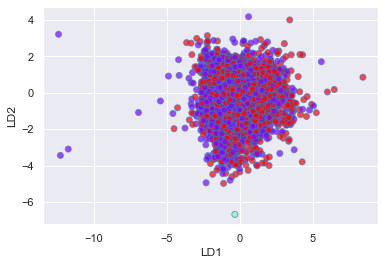

In [50]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

plt.xlabel('LD1')
plt.ylabel('LD2')
plt.scatter(
    X_train_lda[:,0],
    X_train_lda[:,1],
    c=y_train,
    cmap='rainbow',
    alpha=0.7,
    edgecolors='b'
)

In [51]:
# Show the predictions
model = LinearDiscriminantAnalysis()
model = model.fit(X_train_lda, y_train)
preds = model.predict(X_test_lda)
# predictions = model.predict_proba(X_test)

In [52]:
# Show the model metrics
print (classification_report(y_test, preds))
print ("Accuracy:","{:.2%}".format(accuracy_score(y_test, preds)))
pd.DataFrame({'Test Set':y_test, 'Predictions': preds})

              precision    recall  f1-score   support

          -1       0.55      0.43      0.48      1518
           0       0.00      0.00      0.00         1
           1       0.54      0.65      0.59      1562

    accuracy                           0.54      3081
   macro avg       0.36      0.36      0.36      3081
weighted avg       0.54      0.54      0.54      3081

Accuracy: 54.27%


,Test Set,Predictions
DateTime,,
2021-06-01 09:00:00+00:00,1,1
2020-03-17 13:00:00+00:00,-1,1
2020-03-10 11:00:00+00:00,1,-1
2021-02-01 19:00:00+00:00,1,1
2020-08-21 19:00:00+00:00,-1,1
...,...,...
2020-06-06 05:00:00+00:00,1,1
2020-04-03 03:00:00+00:00,-1,-1
2021-06-18 17:00:00+00:00,-1,1


### PCA

In [53]:
# Principal Component Analysis (PCA)
# PCA selects the components which would result in the highest spread (retain the most information)
# n_components represents the number of gerated features from dimensionality reduction
pca = PCA(n_components=min(n_features, n_classes - 1))

# pca_model = pca.fit(X_train, y_train)
# X_train_pca = pca.fit_transform(X_train, y_train)
pca = pca.fit(X_train, y_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
pca.explained_variance_ratio_

array([0.77158467, 0.06973036])

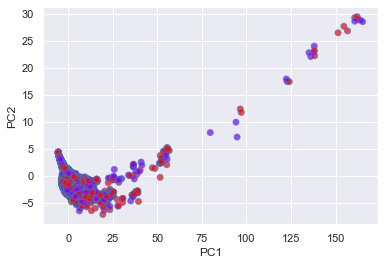

In [54]:
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.scatter(
    X_train_pca[:,0],
    X_train_pca[:,1],
    c=y_train,
    cmap='rainbow',
    alpha=0.7,
    edgecolors='b'
)

In [55]:
# Show the predictions
model = model.fit(X_train_pca, y_train)
preds = model.predict(X_test_pca)
# predictions = model.predict_proba(X_test)


In [1]:
# Show the model metrics
from FiScrape.ml_tools import class_signal_summary
print (classification_report(y_test, preds))
print ("Accuracy:","{:.2%}".format(accuracy_score(y_test, preds)))
pca_tvp = class_signal_summary(y_test, preds)
pca_tvp

NameError: name 'classification_report' is not defined

# Trading

In [58]:
train_size = int(len(dset) * 0.8)
test_size = len(dset) - train_size
train_set, test_set = dset.iloc[0:train_size],dset.iloc[train_size:len(dset)]

In [59]:
test_set['Prediction'] = preds
test_set
# test_set.rename(columns={'Open': 'open', 'High':'high', 'Low':'low', 'Close':'close'})

,Open,High,Low,Close,Volume,Year,Quarter,Month,Day_of_Week,Hour,...,target,Articles,Subjectivity,Polarity,Compound,Negative,Neutral,Positive,Current_Open,Prediction
DateTime,,,,,,,,,,,,,,,,,,,,,
2021-05-20 11:00:00+00:00,39932.06,40479.79,39493.20,40399.99,8945.290938,2021.0,2.0,5.0,3.0,10.0,...,1,2.0,0.445833,0.312500,0.37565,0.000,0.9005,0.0995,40399.99,1
2021-05-20 12:00:00+00:00,40399.99,40690.56,39701.00,40475.17,7448.043731,2021.0,2.0,5.0,3.0,11.0,...,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,40476.68,1
2021-05-20 13:00:00+00:00,40476.68,41975.00,40086.09,41699.99,12123.205654,2021.0,2.0,5.0,3.0,12.0,...,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,41699.99,1
2021-05-20 14:00:00+00:00,41699.99,42451.67,41351.13,41713.33,10904.793573,2021.0,2.0,5.0,3.0,13.0,...,-1,1.0,0.447222,-0.241667,-0.42150,0.094,0.9060,0.0000,41721.02,1
2021-05-20 15:00:00+00:00,41721.02,42200.00,41223.42,41439.32,8729.815606,2021.0,2.0,5.0,3.0,14.0,...,-1,1.0,0.500000,0.066667,-0.40190,0.074,0.9260,0.0000,41436.50,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-26 07:00:00+00:00,42069.03,42184.06,41930.70,41963.14,1095.529170,2021.0,3.0,9.0,6.0,6.0,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41963.13,1
2021-09-26 08:00:00+00:00,41963.13,42060.00,40750.00,41231.34,5678.138050,2021.0,3.0,9.0,6.0,7.0,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41227.07,1
2021-09-26 09:00:00+00:00,41227.07,41691.31,41037.13,41607.53,4167.656810,2021.0,3.0,9.0,6.0,8.0,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41607.53,1


In [60]:
# test_set['Open'] = test_set['Open']/10000
# test_set['High'] = test_set['High']/10000
# test_set['Low'] = test_set['Low']/10000
# test_set['Close'] = test_set['Close']/10000
# test_set['Predictions'] = test_set['Predictions'].replace(0, -1)
# test_set

# Backtesting Environment

In [61]:
pd.set_option('display.expand_frame_repr', False)
np.random.seed(42)
import seaborn as sns
sns.set_style('darkgrid')

In [62]:
def format_time(t):
    m_, s = divmod(t, 60)
    h, m = divmod(m_, 60)
    return f'{h:>02.0f}:{m:>02.0f}:{s:>02.0f}'

## Custom Commission Scheme

In [63]:
class FixedCommisionScheme(bt.CommInfoBase):
    """
    Simple fixed commission scheme for demo
    """
    params = (
        ('commission', 0.00075),
        ('stocklike', True),
        ('commtype', bt.CommInfoBase.COMM_FIXED),
    )

    def _getcommission(self, size, price, pseudoexec):
        return abs(size) * self.p.commission

## DataFrame Loader

In [64]:
OHLCV = ['Open', 'High', 'Low', 'Close']

# class to define the columns we will provide
class SignalData(bt.feeds.PandasData):
    """
    Define pandas DataFrame structure
    """
    cols = OHLCV + ['Current_Open'] + ['predicted']

# create lines
    lines = tuple(cols)
# define parameters
    params = {c: -1 for c in cols}
    params.update({'datetime': None})
    params = tuple(params.items())

## Strategy

In [66]:
class BasicClassifier(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.datetime(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.data_current_open = self.datas[0].Current_Open
        self.dataclose = self.datas[0].close
        self.data_predicted = self.datas[0].Prediction

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Current_Open, %.2f' % self.data_current_open[0])
        self.log('Close, %.2f' % self.dataclose[0])
        self.log('Prediction, %.2f' % self.data_predicted[0])

        if not self.position:
            if self.data_predicted > 0:
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                self.buy()
        elif self.data_predicted < 0: 
            self.close()

In [76]:
class MLStrategy(bt.Strategy):
    """A basic one-step machine learning classification pipeline for either a portfolio or single security."""
    params = (('n_positions', 1),
              ('min_positions', 0),
              ('verbose', False),
              ('log_file', 'backtest.csv'))

    def log(self, txt, dt=None):
        """ Logger for the strategy"""
        dt = dt or self.datas[0].datetime.datetime(0)
        with Path(self.p.log_file).open('a') as f:
            log_writer = csv.writer(f)
            log_writer.writerow([dt.isoformat()] + txt.split(','))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        # Check if an order has been completed
        # broker could reject order if not enough cash
        if self.p.verbose:
            if order.status in [order.Completed]:
                p = order.executed.price
                if order.isbuy():
                    self.log(f'{order.data._name},BUY executed,{p:.2f}')
                elif order.issell():
                    self.log(f'{order.data._name},SELL executed,{p:.2f}')

            elif order.status in [order.Canceled, order.Margin, order.Rejected]:
                self.log(f'{order.data._name},Order Canceled/Margin/Rejected')

    # bt calls prenext instead of next unless
    # all datafeeds have current values
    # => call next to avoid duplicating logic
    def prenext(self):
        self.next()

    def next(self):
        today = self.datas[0].datetime.date()
#         if today.weekday() not in [0, 3]: # only trade on Mondays;
#             return
        positions = [d._name for d, pos in self.getpositions().items() if pos]
        up, down = {}, {}
        missing = not_missing = 0
        for data in self.datas:
            if data.datetime.date() == today:
                if data.predicted[0] > 0:
                    up[data._name] = data.predicted[0]
                elif data.predicted[0] < 0:
                    down[data._name] = data.predicted[0]

        # sort dictionaries ascending/descending by value
        # returns list of tuples
        shorts = sorted(down, key=down.get)[:self.p.n_positions]
        longs = sorted(up, key=up.get, reverse=True)[:self.p.n_positions]
        n_shorts, n_longs = len(shorts), len(longs)
        
        # only take positions if at least min_n longs and shorts
        if n_shorts < self.p.min_positions or n_longs < self.p.min_positions:
            longs, shorts = [], []
        for ticker in positions:
            if ticker not in longs + shorts:
                self.order_target_percent(data=ticker, target=0)
                self.log(f'{ticker},CLOSING ORDER CREATED')

        short_target = -1 / max(self.p.n_positions, n_shorts)
        long_target = 1 / max(self.p.n_positions, n_longs)
        for ticker in shorts:
            self.order_target_percent(data=ticker, target=short_target)
            self.log('{ticker},SHORT ORDER CREATED')
        for ticker in longs:
            self.order_target_percent(data=ticker, target=long_target)
            self.log('{ticker},LONG ORDER CREATED')

In [77]:
# class LMAStrategy(bt.Strategy):
 
#     def __init__(self):
#         ma_fast = bt.ind.SMA(period = 50)
#         ma_slow = bt.ind.SMA(period = 200)
         
#         self.crossover = bt.ind.CrossOver(ma_fast, ma_slow)
 
#     def next(self):
#         if not self.position:
#             if self.crossover > 0: 
#                 self.buy()
#         elif self.crossover < 0: 
#             self.close()

class LMAStrategy(bt.Strategy):
    """The contrarian version of the widely used, basic, SMA crossover CTA strategy, for either a portfolio or single security.
    Used here for comparison & illustrative purposes."""
 
    def __init__(self):
        ma_fast = bt.ind.SMA(period = 50)
        ma_slow = bt.ind.SMA(period = 200)
         
        self.crossover = bt.ind.CrossOver(ma_fast, ma_slow)
        
    params = (('n_positions', 1),
              ('min_positions', 0),
              ('verbose', False),
              ('log_file', 'backtest.csv'))

    def log(self, txt, dt=None):
        """ Logger for the strategy"""
        dt = dt or self.datas[0].datetime.datetime(0)
        with Path(self.p.log_file).open('a') as f:
            log_writer = csv.writer(f)
            log_writer.writerow([dt.isoformat()] + txt.split(','))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        # Check if an order has been completed
        # broker could reject order if not enough cash
        if self.p.verbose:
            if order.status in [order.Completed]:
                p = order.executed.price
                if order.isbuy():
                    self.log(f'{order.data._name},BUY executed,{p:.2f}')
                elif order.issell():
                    self.log(f'{order.data._name},SELL executed,{p:.2f}')

            elif order.status in [order.Canceled, order.Margin, order.Rejected]:
                self.log(f'{order.data._name},Order Canceled/Margin/Rejected')

    # bt calls prenext instead of next unless
    # all datafeeds have current values
    # => call next to avoid duplicating logic
    def prenext(self):
        self.next()

    def next(self):
        today = self.datas[0].datetime.date()
#         if today.weekday() not in [0, 3]: # only trade on Mondays;
#             return
        positions = [d._name for d, pos in self.getpositions().items() if pos]
        up, down = {}, {}
        missing = not_missing = 0
        for data in self.datas:
            if data.datetime.date() == today:
                if self.crossover[0] < 0:
                    up[data._name] = self.crossover[0]
                elif self.crossover[0] > 0:
                    down[data._name] = self.crossover[0]

        # sort dictionaries ascending/descending by value
        # returns list of tuples
        shorts = sorted(down, key=down.get)[:self.p.n_positions]
        longs = sorted(up, key=up.get, reverse=True)[:self.p.n_positions]
        n_shorts, n_longs = len(shorts), len(longs)
        
        # only take positions if at least min_n longs and shorts
        if n_shorts < self.p.min_positions or n_longs < self.p.min_positions:
            longs, shorts = [], []
        for ticker in positions:
            if ticker not in longs + shorts:
                self.order_target_percent(data=ticker, target=0)
                self.log(f'{ticker},CLOSING ORDER CREATED')

        short_target = -1 / max(self.p.n_positions, n_shorts)
        long_target = 1 / max(self.p.n_positions, n_longs)
        for ticker in shorts:
            self.order_target_percent(data=ticker, target=short_target)
            self.log('{ticker},SHORT ORDER CREATED')
        for ticker in longs:
            self.order_target_percent(data=ticker, target=long_target)
            self.log('{ticker},LONG ORDER CREATED')

In [78]:
class SMAStrategy(bt.Strategy):
    """Simple Moving average crossover for either a portfolio or single security.
    Used here for comparison & illustrative purposes."""
 
    def __init__(self):
        ma_fast = bt.ind.SMA(period = 50)
        dataclose = self.datas[0].close
         
        self.crossover = bt.ind.CrossOver(ma_fast, dataclose)

    params = (('n_positions', 1),
              ('min_positions', 0),
              ('verbose', False),
              ('log_file', 'backtest.csv'))

    def log(self, txt, dt=None):
        """ Logger for the strategy"""
        dt = dt or self.datas[0].datetime.datetime(0)
        with Path(self.p.log_file).open('a') as f:
            log_writer = csv.writer(f)
            log_writer.writerow([dt.isoformat()] + txt.split(','))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        # Check if an order has been completed
        # broker could reject order if not enough cash
        if self.p.verbose:
            if order.status in [order.Completed]:
                p = order.executed.price
                if order.isbuy():
                    self.log(f'{order.data._name},BUY executed,{p:.2f}')
                elif order.issell():
                    self.log(f'{order.data._name},SELL executed,{p:.2f}')

            elif order.status in [order.Canceled, order.Margin, order.Rejected]:
                self.log(f'{order.data._name},Order Canceled/Margin/Rejected')

    # bt calls prenext instead of next unless
    # all datafeeds have current values
    # => call next to avoid duplicating logic
    def prenext(self):
        self.next()

    def next(self):
        today = self.datas[0].datetime.date()
#         if today.weekday() not in [0, 3]: # only trade on Mondays;
#             return
        positions = [d._name for d, pos in self.getpositions().items() if pos]
        up, down = {}, {}
        missing = not_missing = 0
        for data in self.datas:
            if data.datetime.date() == today:
                if self.crossover[0] > 0:
                    up[data._name] = self.crossover[0]
                elif self.crossover[0] < 0:
                    down[data._name] = self.crossover[0]

        # sort dictionaries ascending/descending by value
        # returns list of tuples
        shorts = sorted(down, key=down.get)[:self.p.n_positions]
        longs = sorted(up, key=up.get, reverse=True)[:self.p.n_positions]
        n_shorts, n_longs = len(shorts), len(longs)
        
        # only take positions if at least min_n longs and shorts
        if n_shorts < self.p.min_positions or n_longs < self.p.min_positions:
            longs, shorts = [], []
        for ticker in positions:
            if ticker not in longs + shorts:
                self.order_target_percent(data=ticker, target=0)
                self.log(f'{ticker},CLOSING ORDER CREATED')

        short_target = -1 / max(self.p.n_positions, n_shorts)
        long_target = 1 / max(self.p.n_positions, n_longs)
        for ticker in shorts:
            self.order_target_percent(data=ticker, target=short_target)
            self.log('{ticker},SHORT ORDER CREATED')
        for ticker in longs:
            self.order_target_percent(data=ticker, target=long_target)
            self.log('{ticker},LONG ORDER CREATED')

## Create and Configure Cerebro Instance

In [71]:
cerebro = bt.Cerebro()  # create a "Cerebro" instance
start_nav = 100000.0
comminfo = FixedCommisionScheme()
cerebro.broker.addcommissioninfo(comminfo)
cerebro.broker.setcash(start_nav)
print ("Opening NAV: ${:,.2f}".format(start_nav))

Opening NAV: $100,000.00


## Add input data

In [72]:
# # instantiate SignalData class
# data = SignalData(dataname=test_set)
# # instantiate Cerebro, add strategy, data, initial cash, commission and pyfolio for performance analysis
# cerebro = bt.Cerebro(stdstats = True, cheat_on_open=True)
# cerebro.addstrategy(Classifier)
# cerebro.adddata(data)
# cerebro.broker.setcash(10000000.0)
# cerebro.broker.setcommission(commission=0.02)
# cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
# # run the backtest
# print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
# backtest_result = cerebro.run()
# print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

In [73]:
# tickers = {'BTCUSDT': test_set}
tickers = {'BTCUSDT': test_set}

for ticker in tickers:
    bt_df = tickers[ticker]
    bt_df.index.name = 'datetime'
    bt_df = bt_df.rename(columns={'Prediction':'predicted'})
    bt_data = SignalData(dataname=bt_df)
    cerebro.adddata(bt_data, name=ticker)

## Run Backtest

In [74]:
# cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
# cerebro.addanalyzer(btanalyzers.Transactions, _name = "trans")
# cerebro.addstrategy(MLStrategy, n_positions=1, min_positions=0, 
#                     verbose=True, log_file='bt_log.csv')
# start = time()
# results = cerebro.run()
# ending_value = cerebro.broker.getvalue()
# duration = time() - start
# n_trades = len(results[0].analyzers.trans.get_analysis()) 

# print ("Test Start:", bt_df.index.min())
# print ("Test End:", bt_df.index.max())
# test_dt_len = ((bt_df.index.max() - bt_df.index.min()).total_seconds())/(24*60*60)
# print (f"Days: {test_dt_len:,.2f}")

# print ("Opening NAV: ${:,.2f}".format(start_nav))
# print(f'Closing NAV ${ending_value:,.2f}')
# gross_ret = (ending_value/start_nav)-1
# print ("Gross Return: {:,.2%}".format(gross_ret))
# print(f'Duration: {format_time(duration)}')
# print(f'Trades: {n_trades:,}')

In [79]:
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
cerebro.addanalyzer(btanalyzers.Transactions, _name = "trans")
cerebro.addstrategy(MLStrategy, n_positions=1, min_positions=0, 
                    verbose=True, log_file='bt_log.csv')
start = time()
results = cerebro.run()
ending_value = cerebro.broker.getvalue()
duration = time() - start
n_trades = len(results[0].analyzers.trans.get_analysis()) 

print ("Test Start:", bt_df.index.min())
print ("Test End:", bt_df.index.max())
test_dt_len = ((bt_df.index.max() - bt_df.index.min()).total_seconds())/(24*60*60)
print (f"Days: {test_dt_len:,.2f}")

print ("Opening NAV: ${:,.2f}".format(start_nav))
print(f'Closing NAV ${ending_value:,.2f}')
gross_ret = (ending_value/start_nav)-1
print ("Gross Return: {:,.2%}".format(gross_ret))
print(f'Duration: {format_time(duration)}')
print(f'Trades: {n_trades:,}')

Test Start: 2021-05-20 11:00:00+00:00
Test End: 2021-09-26 11:00:00+00:00
Days: 129.00
Opening NAV: $100,000.00
Closing NAV $105,206.76
Gross Return: 5.21%
Duration: 00:00:02
Trades: 1


## Get pyfolio inputs

In [22]:
# prepare pyfolio inputs
pyfolio_analyzer = results[0].analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfolio_analyzer.get_pf_items()

returns.to_hdf('backtrader.h5', 'returns')
positions.to_hdf('backtrader.h5', 'positions')
transactions.to_hdf('backtrader.h5', 'transactions/')
gross_lev.to_hdf('backtrader.h5', 'gross_lev')

## Run pyfolio analysis

In [23]:
returns = pd.read_hdf('backtrader.h5', 'returns')
positions = pd.read_hdf('backtrader.h5', 'positions')
transactions = pd.read_hdf('backtrader.h5', 'transactions/')
gross_lev = pd.read_hdf('backtrader.h5', 'gross_lev')

In [24]:
returns

index
2019-12-21 00:00:00+00:00    0.000000
2019-12-22 00:00:00+00:00    0.000000
2019-12-23 00:00:00+00:00    0.000000
2019-12-24 00:00:00+00:00    0.000000
2019-12-25 00:00:00+00:00    0.000000
                               ...   
2021-09-17 00:00:00+00:00    0.000000
2021-09-18 00:00:00+00:00    0.000000
2021-09-19 00:00:00+00:00    0.000000
2021-09-20 00:00:00+00:00    0.013753
2021-09-21 00:00:00+00:00    0.000000
Name: return, Length: 641, dtype: float64

In [25]:
bench_name = 'CBBTCUSD' # 'SP500'
benchmark = web.DataReader(bench_name, 'fred', returns.index.min(), returns.index.max()).squeeze()
benchmark = benchmark.pct_change().tz_localize('UTC')
benchmark

DATE
2019-12-21 00:00:00+00:00         NaN
2019-12-22 00:00:00+00:00    0.056977
2019-12-23 00:00:00+00:00   -0.030705
2019-12-24 00:00:00+00:00   -0.007968
2019-12-25 00:00:00+00:00   -0.008968
                               ...   
2021-09-16 00:00:00+00:00   -0.006943
2021-09-17 00:00:00+00:00   -0.009104
2021-09-18 00:00:00+00:00    0.020327
2021-09-19 00:00:00+00:00   -0.021310
2021-09-20 00:00:00+00:00   -0.090534
Name: CBBTCUSD, Length: 640, dtype: float64

In [26]:
daily_tx = transactions.groupby(level=0)
longs = daily_tx.value.apply(lambda x: x.where(x>0).sum())
shorts = daily_tx.value.apply(lambda x: x.where(x<0).sum())

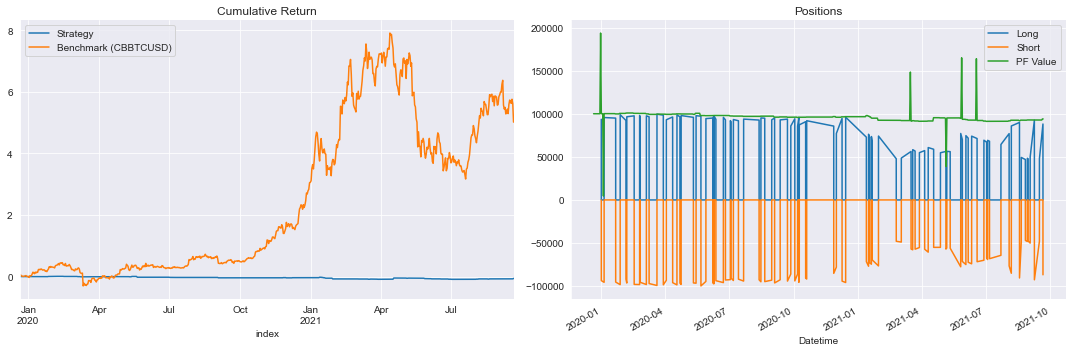

In [27]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

df = returns.to_frame('Strategy').join(benchmark.to_frame(f'Benchmark ({bench_name})'))
df.add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Return')

longs.plot(label='Long',ax=axes[1], title='Positions')
shorts.plot(ax=axes[1], label='Short')
positions.cash.plot(ax=axes[1], label='PF Value')
axes[1].legend()
sns.despine()
fig.tight_layout();

Start date,2021-05-13
End date,2021-09-15
Total months,6
,Backtest
Annual return,-13.507%
Cumulative returns,-6.999%
Annual volatility,56.053%
Sharpe ratio,0.03
Calmar ratio,-0.30
Stability,0.42
Max drawdown,-44.542%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,42.50,2021-05-13,2021-05-23,2021-08-07,62
1,9.86,2021-08-09,2021-09-10,NaT,NaN
2,2.61,2021-08-07,2021-08-08,2021-08-09,1
3,NaN,NaT,NaT,NaT,NaN
4,NaN,NaT,NaT,NaT,NaN


ConversionError: Failed to convert value(s) to axis units: (NaT, Timestamp('2021-09-15 00:00:00+0000', tz='UTC'))

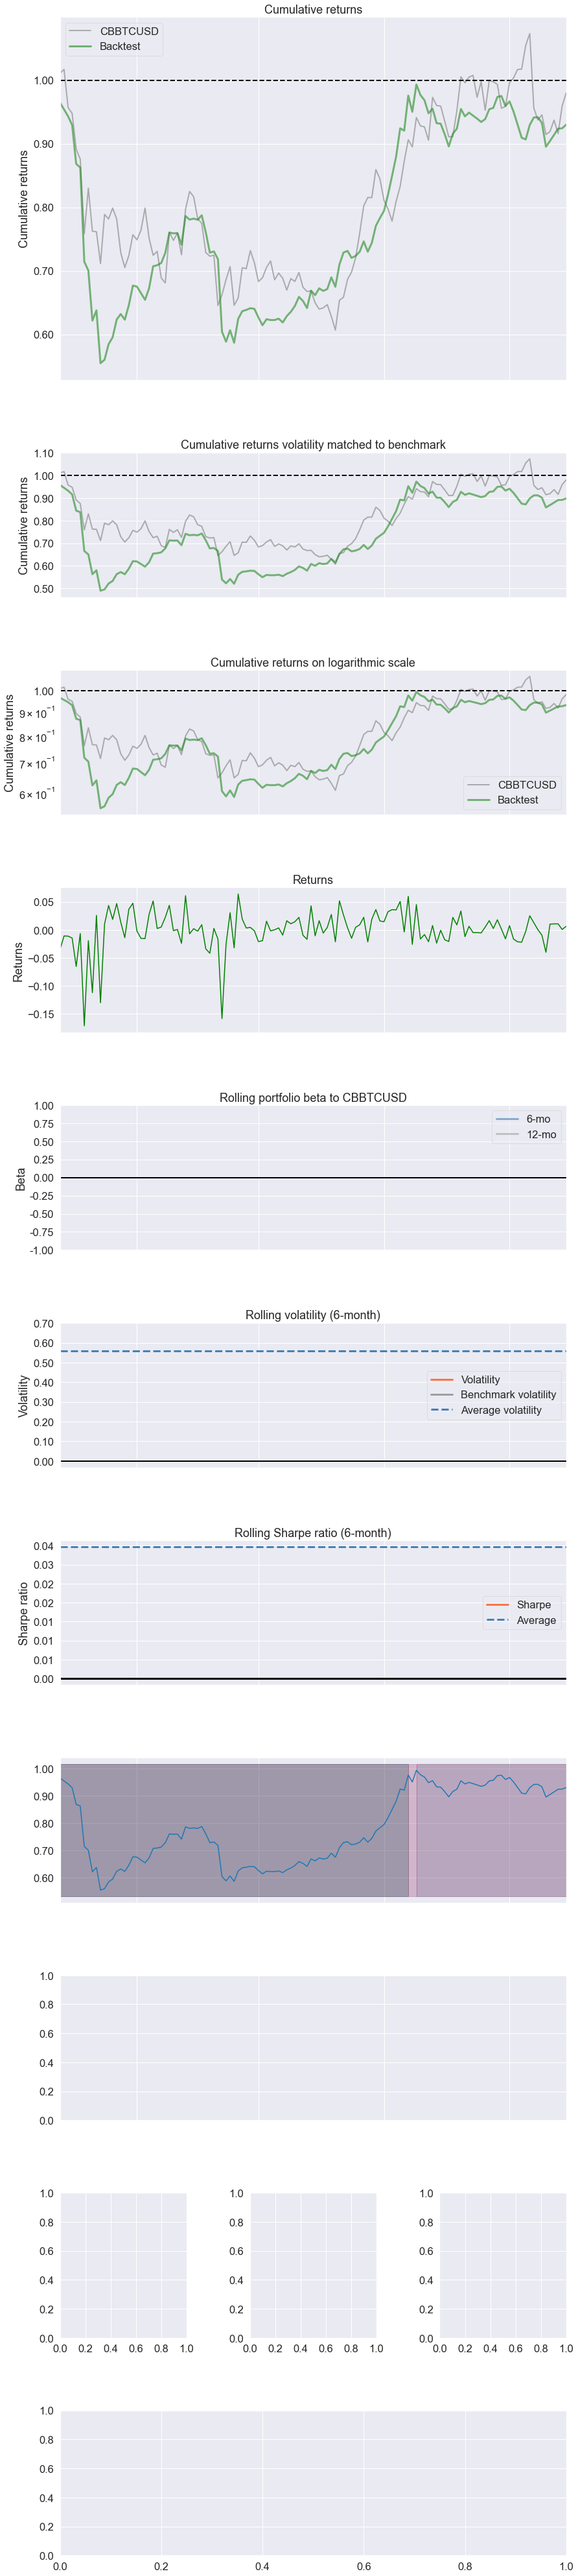

In [101]:
pf.create_full_tear_sheet(returns,
                          transactions=transactions,
                          positions=positions,
                          benchmark_rets=benchmark.dropna())

<AxesSubplot:title={'center':'Rolling portfolio beta to CBBTCUSD'}, ylabel='Beta'>

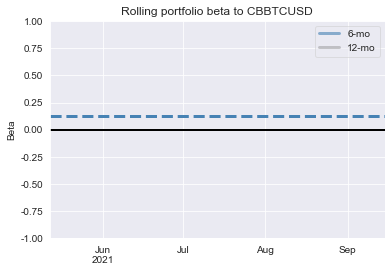

In [103]:
pf.plotting.plot_rolling_beta(returns, factor_returns=benchmark.dropna(),legend_loc='best',ax=None)

<AxesSubplot:title={'center':'Rolling volatility (6-month)'}, ylabel='Volatility'>

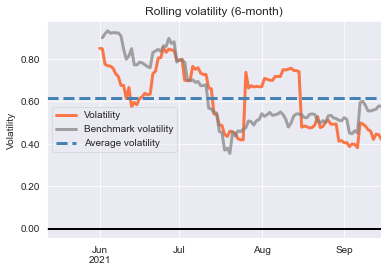

In [104]:
pf.plotting.plot_rolling_volatility(returns, factor_returns=benchmark.dropna(),
                            rolling_window=21,
                            legend_loc='best', ax=None)

<AxesSubplot:title={'center':'Rolling Sharpe ratio (6-month)'}, ylabel='Sharpe ratio'>

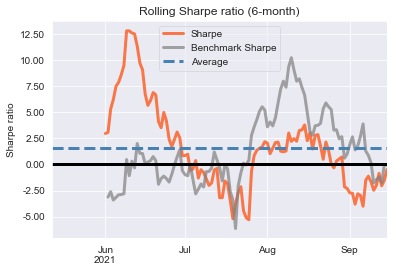

In [105]:
pf.plotting.plot_rolling_sharpe(returns, factor_returns=benchmark.dropna(),
                        rolling_window=21,
                        legend_loc='best', ax=None)

<AxesSubplot:title={'center':'Daily turnover'}, ylabel='Turnover'>

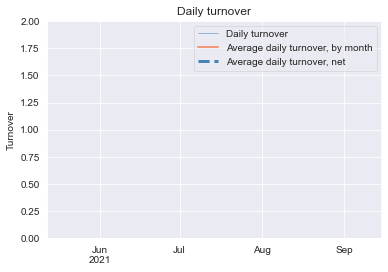

In [106]:
pf.plotting.plot_turnover(returns, transactions, positions, turnover_denom='AGB', # turnover_denom='portfolio_value',
                  legend_loc='best', ax=None)